In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch #https://github.com/facebookresearch/esm

from Bio.PDB import PDBParser, PPBuilder
import pcmap
import math

Picking random binder and target sequences from the meta-analysis dataset, merginf them to single entry and predicting structure using AF-multimer:<br>
`../data/RAEL.pdb`

In [2]:
pdb_path = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/DEEY.pdb"
interaction_df = pd.read_csv("../data/meta_analysis/interaction_df_metaanal.csv", index_col = 0).drop(columns = ["binder_id", "target_id"]).rename(columns={
    "A_seq" : "binder_seq",
    "B_seq" : "target_seq"
})
interaction_df[interaction_df["binder"]==True] # index 3468

# sample_df = interaction_df.sample(n=1, random_state=22)
seq = interaction_df["binder_seq"].iloc[3468] + interaction_df["target_seq"].iloc[3468]
print("Sequence:", seq, len(seq))

Sequence: DEEYDEIQELYREASKQLKKGNRERAIQLLEETLKKAEEQDDEVAAKDIKRLLDMLELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLCTGNSSHSSWDNQCQCTSSATRNTTKQVTPQPEEQKERKTTEMQSPMQPVDQASLPGHCREPPPWENEATERIYHFVVGQMVYYQCVQGYRALHRGPAESVCKMTHGKTRWTQPQLICTG 221


#### Contact map computed using `../data/RAEL.pdb` structure

Contact map size: (221, 221)


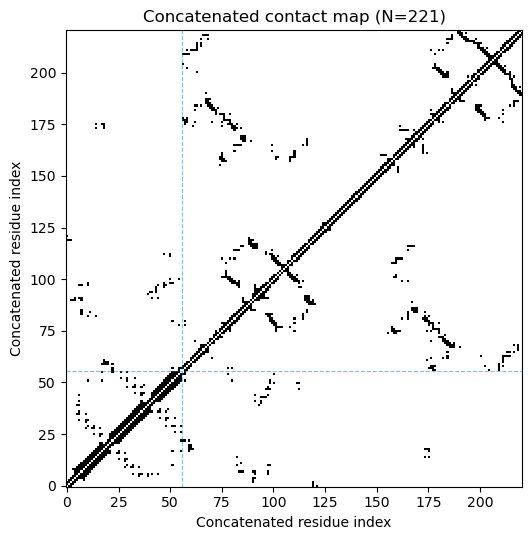

In [3]:
# --- Build a single concatenated index across chains ---
cmap = pcmap.contactMap(pdb_path)

# choose the order you want chains to appear in the concatenated sequence
chain_order = ["A", "B"]  # adjust to your PDB (e.g., ["A","B","C"])

def resid_key(entry):
    # robust key: (chain, resID, insCode) if available
    ch = entry.get("chainID") or entry.get("chain") or entry.get("auth_asym_id") or "?"
    rid = int(entry["resID"])
    icode = entry.get("iCode") or entry.get("insCode") or ""
    return (ch, rid, icode)

# collect all residue keys that appear (roots + partners)
keys = []
for pos_dict in cmap["data"]:
    keys.append(resid_key(pos_dict["root"]))
    for inter in pos_dict["partners"]:
        keys.append(resid_key(inter))

uniq_keys = sorted(set(keys), key=lambda x: (chain_order.index(x[0]) if x[0] in chain_order else 999, x[1], x[2]))
idx = {k: i for i, k in enumerate(uniq_keys)}
N = len(uniq_keys)

# --- Fill symmetric binary contact map over concatenated indexing ---
M = np.zeros((N, N), dtype=np.uint8)
for pos_dict in cmap["data"]:
    i = idx[resid_key(pos_dict["root"])]
    for inter in pos_dict["partners"]:
        j = idx[resid_key(inter)]
        M[i, j] = 1
        M[j, i] = 1

print("Contact map size:", M.shape)

# --- Plot, with chain break guides ---
plt.figure(figsize=(5.5, 5.5))
plt.imshow(M, origin="lower", interpolation="nearest", cmap="binary")
plt.title(f"Concatenated contact map (N={N})")
plt.xlabel("Concatenated residue index")
plt.ylabel("Concatenated residue index")

# draw separators between chains
# compute where each chain's block ends in the concatenation
ends = []
curr = -1
for ch in chain_order:
    count = sum(1 for k in uniq_keys if k[0] == ch)
    if count:
        curr += count
        ends.append(curr)

for e in ends[:-1]:  # don't draw after last block
    plt.axhline(e + 0.5, lw=0.8, ls="--", alpha=0.5)
    plt.axvline(e + 0.5, lw=0.8, ls="--", alpha=0.5)

plt.tight_layout()
plt.show()


#### Dinstances between Cα–Cα computed using `../data/RAEL.pdb` and `PDBParser()`

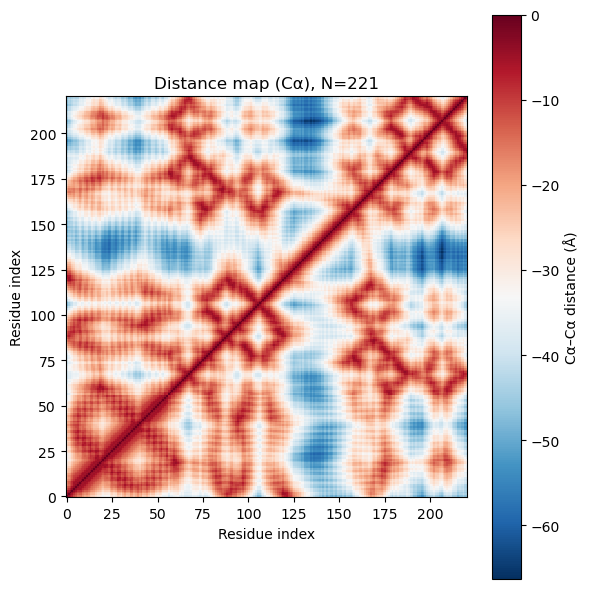

In [4]:
def ca_distance_matrix(pdb_path, chain_id=None):
    struct = PDBParser(QUIET=True).get_structure("s", pdb_path)
    cas, labels = [], []
    for model in struct:
        for chain in model:
            if chain_id and chain.id != chain_id:
                continue
            for res in chain:
                if res.id[0] != " " or "CA" not in res:
                    continue
                cas.append(res["CA"].coord)
                labels.append((chain.id, res.get_resname(), res.id[1], res.id[2].strip()))
            if chain_id:  # stop after chosen chain
                break
        break  # first model only
    X = np.asarray(cas)                     # [N,3]
    D = np.sqrt(((X[:,None,:]-X[None,:,:])**2).sum(-1))  # [N,N]
    return D, labels

D, labels = ca_distance_matrix(pdb_path, chain_id=None)

# Save & plot
# np.savetxt("distance_matrix_ca.csv", D, fmt="%.3f", delimiter=",")
plt.figure(figsize=(6,6))
# plt.imshow(D, origin="lower", interpolation="nearest")
# plt.imshow(-D, origin="lower", interpolation="nearest", cmap="Blues")
plt.imshow(-D, origin="lower", interpolation="nearest", cmap="RdBu_r")
plt.colorbar(label="Cα–Cα distance (Å)")
plt.title(f"Distance map (Cα), N={D.shape[0]}")
plt.xlabel("Residue index")
plt.ylabel("Residue index")
plt.tight_layout()
plt.show()

### Loading ESM2 model

In [5]:
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")
batch_converter = alphabet.get_batch_converter()
model.eval()
model

Using cache found in /zhome/c9/0/203261/.cache/torch/hub/facebookresearch_esm_main


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

### Contact map form the ESM model:

`contacts = model(batch_tokens, repr_layers=[L], return_contacts=True)["contacts"][0]`

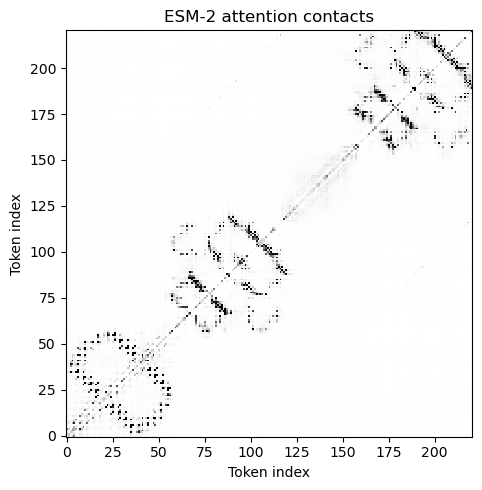

In [6]:
data = [("protein1", seq)]  # <- single sequence

# Make batch
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)  # tensor([L_plus_special])

with torch.no_grad():
    # use the model's last layer automatically
    L = model.num_layers
    out = model(batch_tokens, repr_layers=[L], return_contacts=True)

token_reps = out["representations"][L]      # shape: [1, T, H]
tokens_len = int(batch_lens[0])             # includes BOS/EOS

# Per-sequence embedding (average of residue tokens; skip BOS/EOS)
seq_emb = token_reps[0, 1:tokens_len-1].mean(0)  # shape: [H]

# Contact map (trim to actual tokens_len if needed)
contacts = out["contacts"][0]               # shape: [T, T]
contacts = contacts[:tokens_len, :tokens_len]

plt.figure(figsize=(5,5))
plt.imshow(contacts, origin="lower", interpolation="nearest", cmap="binary")
plt.title("ESM-2 attention contacts")
plt.xlabel("Token index")
plt.ylabel("Token index")
plt.tight_layout()
plt.show()

### Comapring all 3: cmap vs -D vs contacts

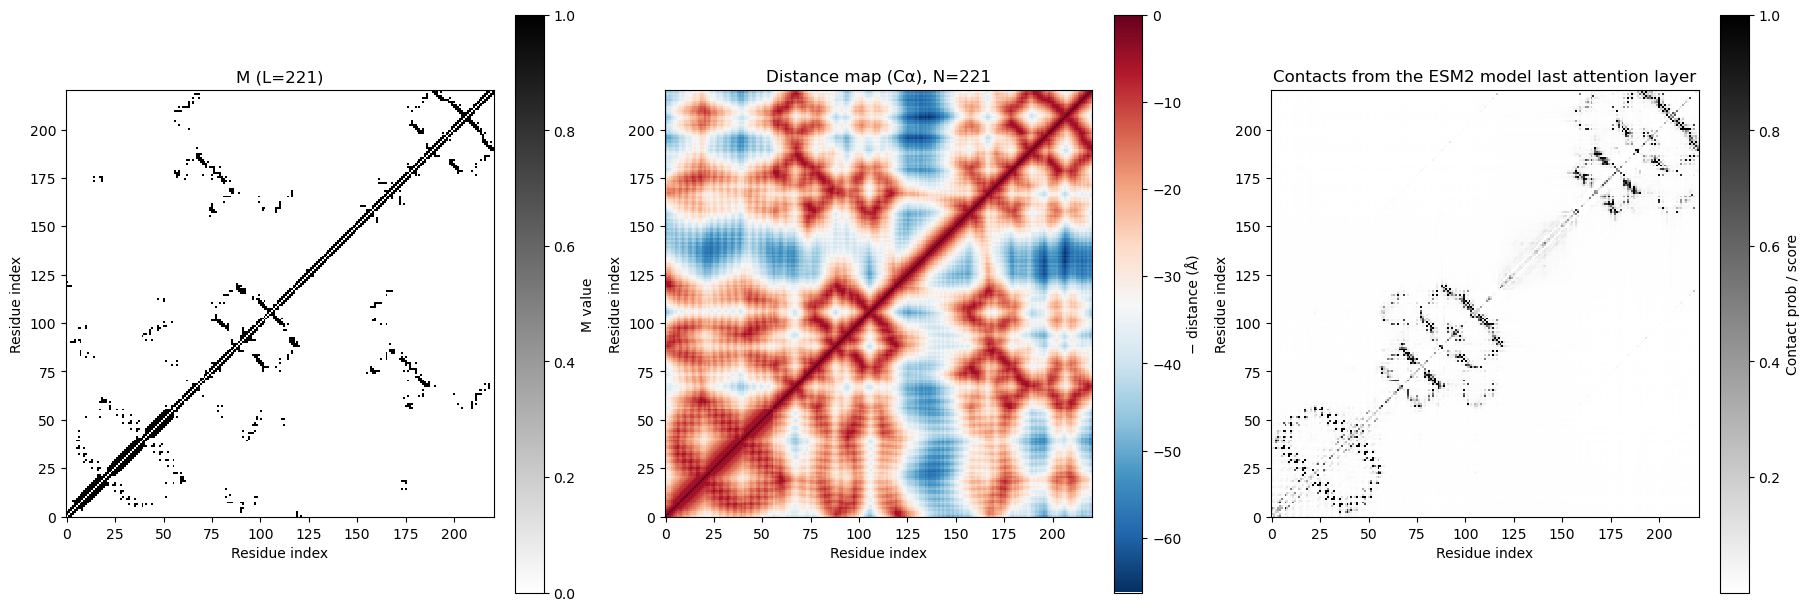

In [7]:
# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# M
im0 = axes[0].imshow(M, origin="lower", interpolation="nearest", cmap="binary")
axes[0].set_title(f"M (L={M.shape[0]})")
axes[0].set_xlabel("Residue index"); axes[0].set_ylabel("Residue index")
cb0 = fig.colorbar(im0, ax=axes[0])
cb0.set_label("M value")

# D (plotted as -D per your example)
im1 = axes[1].imshow(-D, origin="lower", interpolation="nearest", cmap="RdBu_r")
axes[1].set_title(f"Distance map (Cα), N={D.shape[0]}")
axes[1].set_xlabel("Residue index"); axes[1].set_ylabel("Residue index")
cb1 = fig.colorbar(im1, ax=axes[1])
cb1.set_label("− distance (Å)")

# Contacts
im2 = axes[2].imshow(contacts, origin="lower", interpolation="nearest", cmap="binary")
axes[2].set_title("Contacts from the ESM2 model last attention layer")
axes[2].set_xlabel("Residue index"); axes[2].set_ylabel("Residue index")
cb2 = fig.colorbar(im2, ax=axes[2])
cb2.set_label("Contact prob / score")

plt.show()

In [8]:
batch_tokens # encoding of amino acids used

tensor([[ 0, 13,  9,  9, 19, 13,  9, 12, 16,  9,  4, 19, 10,  9,  5,  8, 15, 16,
          4, 15, 15,  6, 17, 10,  9, 10,  5, 12, 16,  4,  4,  9,  9, 11,  4, 15,
         15,  5,  9,  9, 16, 13, 13,  9,  7,  5,  5, 15, 13, 12, 15, 10,  4,  4,
         13, 20,  4,  9,  4, 23, 13, 13, 13, 14, 14,  9, 12, 14, 21,  5, 11, 18,
         15,  5, 20,  5, 19, 15,  9,  6, 11, 20,  4, 17, 23,  9, 23, 15, 10,  6,
         18, 10, 10, 12, 15,  8,  6,  8,  4, 19, 20,  4, 23, 11,  6, 17,  8,  8,
         21,  8,  8, 22, 13, 17, 16, 23, 16, 23, 11,  8,  8,  5, 11, 10, 17, 11,
         11, 15, 16,  7, 11, 14, 16, 14,  9,  9, 16, 15,  9, 10, 15, 11, 11,  9,
         20, 16,  8, 14, 20, 16, 14,  7, 13, 16,  5,  8,  4, 14,  6, 21, 23, 10,
          9, 14, 14, 14, 22,  9, 17,  9,  5, 11,  9, 10, 12, 19, 21, 18,  7,  7,
          6, 16, 20,  7, 19, 19, 16, 23,  7, 16,  6, 19, 10,  5,  4, 21, 10,  6,
         14,  5,  9,  8,  7, 23, 15, 20, 11, 21,  6, 15, 11, 10, 22, 11, 16, 14,
         16,  4, 12, 23, 11,

- `batch_tokens` is a `torch.LongTensor` shaped [1, T] (batch of 1).
- Index 0 (0) is the `BOS` token (begin-of-sequence).
- Last index (2) is the `EOS` token (end-of-sequence).
- Everything in between are amino-acid token IDs.
- In `ESM-2`, `alphabet.cls_idx == 0`, `alphabet.padding_idx == 1`, `alphabet.eos_idx == 2`.

In [9]:
# decode ID --> letter
T = int((batch_tokens != alphabet.padding_idx).sum())
ids = batch_tokens[0, 1:T-1].tolist()             # drop BOS/EOS
letters = [alphabet.get_tok(i) for i in ids]      # map IDs to tokens
seq_back = "".join(letters)
print("T:", T) # kength of the protein sequence + BOS/EOS, i.e., batch tokens 0, 2
print("Decoded residues:", seq_back)

T: 223
Decoded residues: DEEYDEIQELYREASKQLKKGNRERAIQLLEETLKKAEEQDDEVAAKDIKRLLDMLELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLCTGNSSHSSWDNQCQCTSSATRNTTKQVTPQPEEQKERKTTEMQSPMQPVDQASLPGHCREPPPWENEATERIYHFVVGQMVYYQCVQGYRALHRGPAESVCKMTHGKTRWTQPQLICTG


In [10]:
with torch.no_grad():
    repr_layers = list(range(model.num_layers + 1))
    out = model(batch_tokens,
                repr_layers=repr_layers,
                return_contacts=True) 

out.keys()
# out["representations"] # embeddings
# out["attentions"] # all the attentions: 33 layers, 20 heads
# out["contacts"] # contact map

dict_keys(['logits', 'representations', 'attentions', 'contacts'])

In [11]:
out["attentions"].shape

# torch.Size([ 1,   33,   20,   73,   73 ])
#              │     │     │      │     └── src_len  (keys)
#              │     │     │      └──────── tgt_len  (queries)
#              │     │     └─────────────── n_heads  (per layer)
#              │     └───────────────────── n_layers (ESM-2 t33 → 33)
#              └─────────────────────────── batch_size (here 1)

torch.Size([1, 33, 20, 223, 223])

## Plotting last layer (33rd) all the heads separately to see which capture structural information

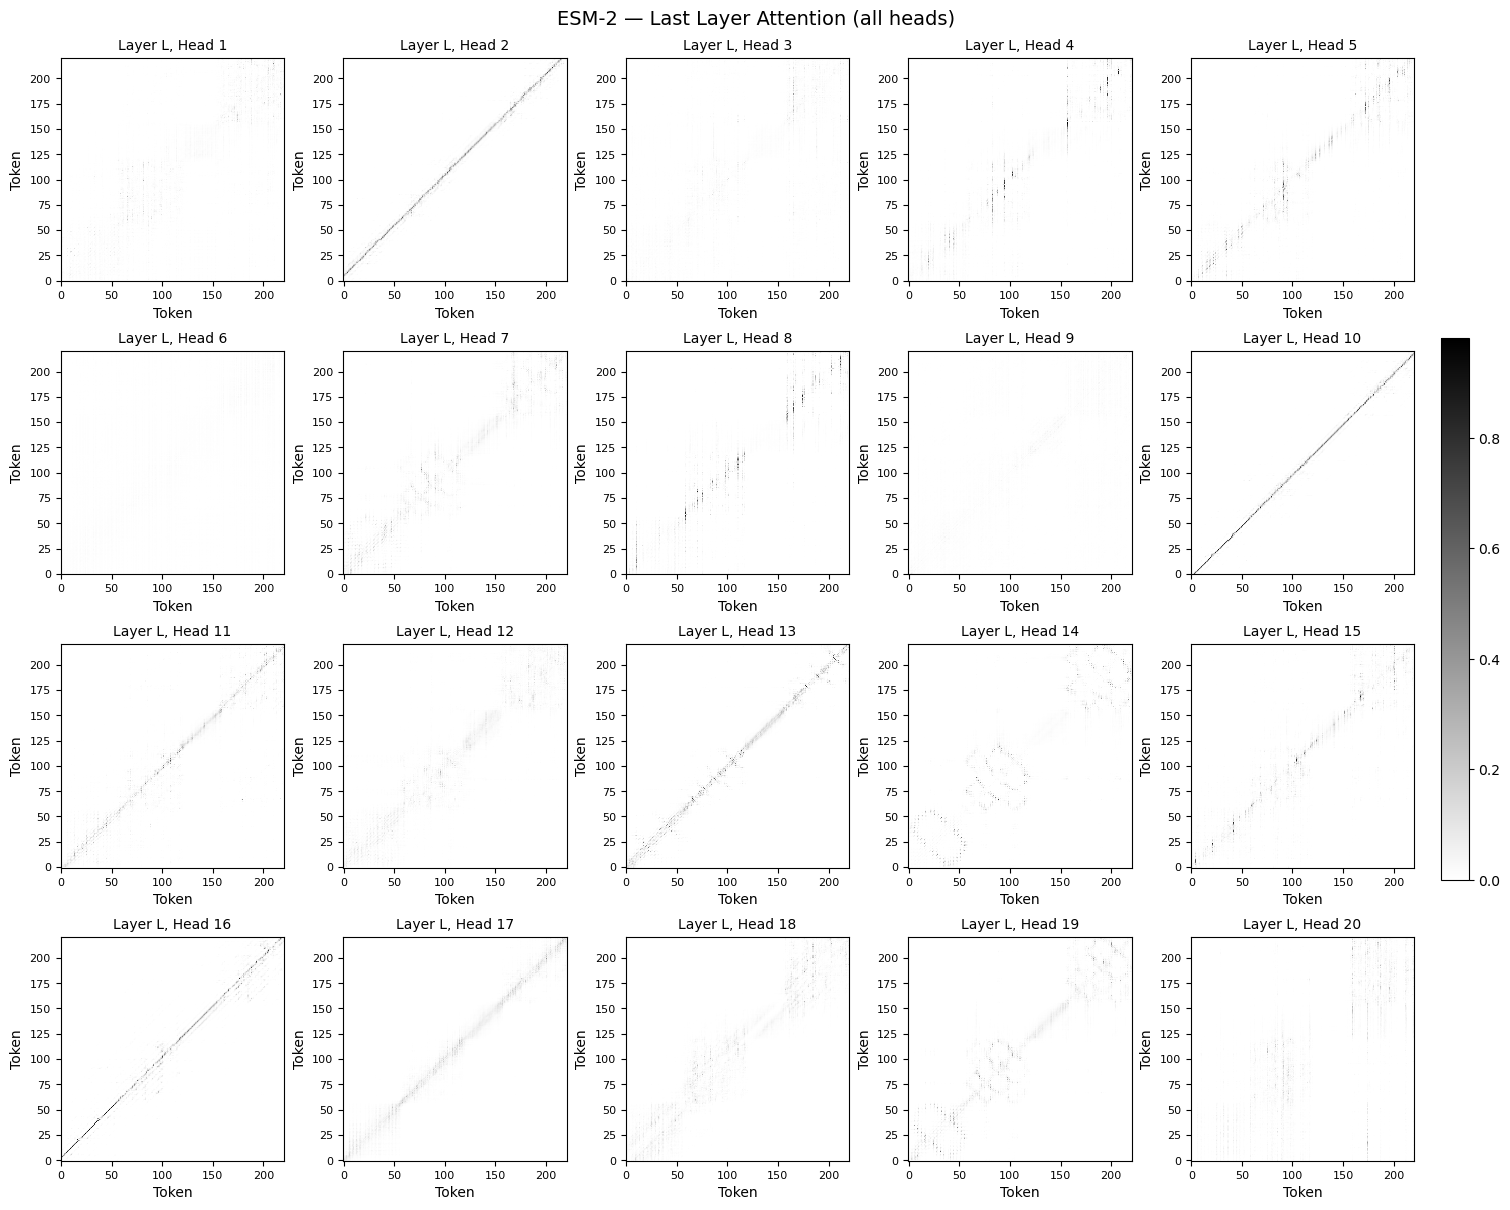

In [12]:
attentions = out["attentions"]
A = attentions[0, -1, :, :, :]   # [H, T', T']
H = A.shape[0]

# Drop BOS/EOS so it’s residue-only
T_valid = int((batch_tokens != alphabet.padding_idx).sum())
if T_valid >= 2:
    A = A[:, 1:-1, 1:-1]                       # [H, Lres, Lres]

# Plot all heads
cols = 5
rows = math.ceil(H / cols)
fig, axes = plt.subplots(rows, cols, figsize=(3.0*cols, 3.0*rows), constrained_layout=True)
axes = axes.ravel()

# Shared color scale (helps compare heads)
vmin = float(A.min())
vmax = float(A.max())

im0 = 0
for h in range(rows*cols):
    ax = axes[h]
    if h < H:
        M = A[h].detach().cpu().numpy()
        im0 = ax.imshow(M, origin="lower", interpolation="nearest", cmap="binary",
                        vmin=vmin, vmax=vmax)
        ax.set_title(f"Layer L, Head {h+1}", fontsize=10)
        ax.set_xlabel("Token"); ax.set_ylabel("Token")
        ax.tick_params(labelsize=8)
    else:
        ax.axis("off")

if im0 is not None:
    fig.colorbar(im0, ax=axes.tolist(), fraction=0.02, pad=0.02)

fig.suptitle("ESM-2 — Last Layer Attention (all heads)", fontsize=14)
plt.show()

### P@L

In [13]:
struct = PDBParser(QUIET=True).get_structure("s", pdb_path)
# collect Cα coords
X = np.asarray(coords) # [length, 3 coordinates]
N = len(X) # length 
D = np.sqrt(((X[:,None,:]-X[None,:,:])**2).sum(-1))  # [N,N] # pairwise distances
T = (D <= 8)
print(D)
# # # remove self and short-range
# i, j = np.triu_indices(N, k=1)
# short = (np.abs(i-j) < 6)
# T[i[short], j[short]] = False
# T[j[short], i[short]] = False

# plt.figure(figsize=(5,5))
# plt.imshow(T, origin="lower", interpolation="nearest", cmap="binary")
# plt.title(f"Contact map (N={T.shape[0]})")
# plt.xlabel("Residue index (sorted by PDB resID)")
# plt.ylabel("Residue index (sorted by PDB resID)")
# plt.tight_layout()
# plt.show()

NameError: name 'coords' is not defined

In [ ]:
D.shape

In [ ]:
# --- 1) build ground-truth contacts (Cα ≤ 8 Å by default) ---
def true_contacts_ca(pdb_path, chain_id=None, cutoff=8.0, min_seq_sep=6):
    struct = PDBParser(QUIET=True).get_structure("s", pdb_path)
    # collect Cα coords
    coords = [res["CA"].coord for res in struct[0]["A"] if res.id[0] == " " and "CA" in res]
    X = np.asarray(coords) # [len, 3 coordinates of Cα]
    N = len(X) # length of the sequence
    D = np.sqrt(((X[:,None,:]-X[None,:,:])**2).sum(-1))  # [N,N] # Cα–Cα pairwise distance matrix
    T = (D <= cutoff) # True where the distance is smaller than cutoff
    # remove self and short-range
    i,j = np.triu_indices(N, k=1)
    short = (np.abs(i-j) < min_seq_sep)
    T[i[short], j[short]] = False
    T[j[short], i[short]] = False

    plt.figure(figsize=(5,5))
    plt.imshow(-D, origin="lower", interpolation="nearest", cmap="binary")
    plt.title(f"Contact map, not filtered (N={T.shape[0]})")
    plt.xlabel("Residue index (sorted by PDB resID)")
    plt.ylabel("Residue index (sorted by PDB resID)")
    plt.tight_layout()
    plt.show()
    
    return T

# --- 2) Precision@K on matrices ---
def precision_at_k(scores, truth_bool, K):
    """scores, truth_bool: NxN (upper triangle used, excluding diagonal)"""
    N = scores.shape[0]
    i, j = np.triu_indices(N, k=1)
    # (optional) exclude short-range already masked in truth_bool
    mask = np.ones_like(i, dtype=bool)
    # keep only pairs that exist in truth (or all pairs if you prefer):
    # mask = np.ones_like(i, dtype=bool)
    s = scores[i, j]
    t = truth_bool[i, j].astype(bool)

    # rank by predicted score (desc) and take top-K
    order = np.argsort(-s)
    top = order[:K]
    return float(t[top].sum()) / K

# --- 3) Convenience wrappers ---
def precision_at_L(scores, truth_bool): 
    N = scores.shape[0]
    return precision_at_k(scores, truth_bool, K=N)

def precision_at_L2(scores, truth_bool): 
    N = scores.shape[0]
    return precision_at_k(scores, truth_bool, K=max(1, N//2))

def precision_at_L5(scores, truth_bool): 
    N = scores.shape[0]
    return precision_at_k(scores, truth_bool, K=max(1, N//5))

# After you run ESM-2 and get "results" and tokens_len
L = int(tokens_len) - 2                 # exclude BOS/EOS
S = out["contacts"][0][:L, :L].cpu().numpy()  # predicted scores (NxN)

T = true_contacts_ca("../data/RAEL.pdb", chain_id="A", cutoff=8.0, min_seq_sep=6)

print("P@L  =", precision_at_L(S, T))
print("P@L/2=", precision_at_L2(S, T))
print("P@L/5=", precision_at_L5(S, T))
